# Approach A — TF-IDF + Cosine Similarity Pipeline

**Research Question:** To what extent do text-based similarities in university strategic plans correlate with external university rankings and institutional classifications?

**Pipeline Overview:**
```
Load Metadata → Load Extracted Text → Preprocess → TF-IDF Vectorize
    → Cosine Similarity Matrix → Spearman Correlation with Rankings
    → Hierarchical Clustering + K-Means → Visualisations → Keyword Analysis
```

**Prerequisites:** Run the following first:
```bash
python src/download_pdfs.py   # download PDFs (or place them manually)
python src/extract_text.py    # extract text from PDFs
```

---
## 0. Imports & Configuration

In [1]:
import re
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# ── paths ─────────────────────────────────────────────────────────────────────
BASE_DIR    = Path('..').resolve()
DATA_DIR    = BASE_DIR / 'data'
TEXT_DIR    = DATA_DIR / 'extracted_text'
OUTPUT_DIR  = BASE_DIR / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
sys.path.insert(0, str(BASE_DIR / 'src'))

# ── colour palette per tier ───────────────────────────────────────────────────
TIER_COLORS = {'Top': '#2196F3', 'Mid': '#FF9800', 'Lower': '#F44336'}
REGION_COLORS = {
    'Europe': '#4CAF50', 'Asia': '#9C27B0',
    'Australia/NZ': '#FF5722', 'North America': '#2196F3',
    'Americas+Africa': '#795548'
}

print('Setup complete.')
print(f'Base dir : {BASE_DIR}')

Setup complete.
Base dir : C:\Users\Shashwat\Documents\Text Analytics Project


---
## 1. Load Metadata

In [2]:
df = pd.read_csv(DATA_DIR / 'metadata.csv')

# short labels for plots
df['label'] = df['university'].str.replace(
    r'University of |University |College ', '', regex=True
).str.slice(0, 22)
df['label'] = df['label'] + ' (' + df['qs_rank'].astype(str) + ')'

print(f"Total universities in corpus: {len(df)}")
print(df.groupby(['region', 'tier']).size().unstack(fill_value=0).to_string())
df.head()

Total universities in corpus: 43
tier             Lower  Mid  Top
region                          
Americas+Africa      2    3    3
Asia                 2    3    5
Australia/NZ         0    8    2
Europe               2    3    5
North America        1    1    3


,university,country,region,qs_rank,qs_rank_numeric,tier,pdf_url,label
0,Imperial College London,United Kingdom,Europe,2,2,Top,https://www.imperial.ac.uk/media/imperial-coll...,Imperial London (2)
1,University of Oxford,United Kingdom,Europe,4,4,Top,https://www.ox.ac.uk/sites/files/oxford/field/...,Oxford (4)
2,ETH Zurich,Switzerland,Europe,7,7,Top,https://ethz.ch/content/dam/ethz/main/eth-zuri...,ETH Zurich (7)
3,Technical University of Munich,Germany,Europe,22,22,Top,https://mediatum.ub.tum.de/doc/1657205/1657205...,Technical Munich (22)
4,Trinity College Dublin,Ireland,Europe,75,75,Top,https://detail.ie/extranet/TCD/strategy/TCD_St...,Trinity Dublin (75)


---
## 2. Load & Preprocess Text

We load each university's extracted `.txt` file and run the preprocessing pipeline:
lowercase → remove URLs/numbers → lemmatize (spaCy) → remove stopwords.

In [3]:
from preprocess import preprocess_corpus, safe_filename

# Check which documents are available on disk
df['txt_path'] = df['university'].apply(
    lambda u: TEXT_DIR / (safe_filename(u) + '.txt')
)
df['has_text'] = df['txt_path'].apply(lambda p: p.exists() and p.stat().st_size > 500)

print(f"Documents available : {df['has_text'].sum()} / {len(df)}")
missing = df[~df['has_text']]['university'].tolist()
if missing:
    print("\nMissing (needs manual download):")
    for m in missing:
        print(f"  {m}")

Documents available : 42 / 43

Missing (needs manual download):
  Universidad de los Andes


In [4]:
# Preprocess all available documents
df_available = df[df['has_text']].reset_index(drop=True)

print('Preprocessing documents…')
df_available = preprocess_corpus(df_available, TEXT_DIR)

# Filter out any docs where preprocessing yielded nothing
df_available = df_available[df_available['processed_text'].str.len() > 100].reset_index(drop=True)
N = len(df_available)
print(f'\n{N} documents ready for analysis.')

# Quick sanity check — word counts
df_available['word_count'] = df_available['processed_text'].apply(lambda t: len(t.split()))
print(df_available[['university', 'tier', 'word_count']].to_string(index=False))

Preprocessing documents…

42 documents ready for analysis.
                        university  tier  word_count
           Imperial College London   Top        4571
              University of Oxford   Top        1706
                        ETH Zurich   Top        9219
    Technical University of Munich   Top        2714
            Trinity College Dublin   Top        2138
                Utrecht University   Mid        4213
         University College Dublin   Mid        1985
              Stockholm University   Mid        3378
         University of Northampton Lower        1671
               University of Split Lower       14351
           University of Hong Kong   Top         426
  Nanyang Technological University   Top        1528
  Hong Kong Polytechnic University   Top        2458
         Seoul National University   Top         315
                 Universiti Malaya   Top        1072
             Nazarbayev University   Mid       10393
                   Anna University   Mid

---
## 3. TF-IDF Vectorization

Each document becomes a high-dimensional vector.  
Key parameters:
- `ngram_range=(1,2)` — captures bigrams like *research excellence*
- `min_df=2` — ignore terms that appear in only one document
- `max_df=0.85` — ignore near-universal boilerplate terms
- `max_features=5000` — limit vocabulary size

In [5]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.85,
    max_features=5000,
    sublinear_tf=True,   # apply log(1+tf) — reduces impact of very frequent terms
)

tfidf_matrix = vectorizer.fit_transform(df_available['processed_text'])
vocab = vectorizer.get_feature_names_out()

print(f'TF-IDF matrix shape : {tfidf_matrix.shape}')
print(f'  {N} documents × {len(vocab)} features')

TF-IDF matrix shape : (42, 5000)
  42 documents × 5000 features


---
## 4. Cosine Similarity Matrix

Compute the N × N pairwise similarity matrix.  
Entry [i, j] = cosine similarity between university i and university j (0 = no overlap, 1 = identical).

In [6]:
sim_matrix = cosine_similarity(tfidf_matrix)
sim_df = pd.DataFrame(
    sim_matrix,
    index=df_available['label'],
    columns=df_available['label']
)

print(f'Similarity matrix: {sim_matrix.shape[0]} × {sim_matrix.shape[1]}')
print(f'Mean pairwise similarity (excluding diagonal): '
      f'{sim_matrix[np.triu_indices(N, k=1)].mean():.4f}')
print(f'Max pairwise similarity (excl. diagonal)    : '
      f'{sim_matrix[np.triu_indices(N, k=1)].max():.4f}')
print(f'Min pairwise similarity                     : '
      f'{sim_matrix[np.triu_indices(N, k=1)].min():.4f}')

Similarity matrix: 42 × 42
Mean pairwise similarity (excluding diagonal): 0.1804
Max pairwise similarity (excl. diagonal)    : 0.4777
Min pairwise similarity                     : 0.0107


---
## 5. Correlation with QS Rankings (Spearman)

**Hypothesis:** Universities with similar rankings use more similar language.

We compute a **ranking-proximity matrix** and correlate it with the similarity matrix.
- Ranking proximity between i and j = `1 / (1 + |rank_i - rank_j|)` — close in rank → near 1, far apart → near 0.
- Both matrices are flattened to 1D (upper triangle only) before correlation.

In [7]:
ranks = df_available['qs_rank_numeric'].values.astype(float)

# ── Ranking proximity matrix ──────────────────────────────────────────────────
rank_diff_matrix = np.abs(ranks[:, None] - ranks[None, :])
rank_prox_matrix = 1.0 / (1.0 + rank_diff_matrix)   # 1 = same rank, →0 as diff grows

# ── Extract upper triangle (no diagonal) ────────────────────────────────────
idx_upper = np.triu_indices(N, k=1)
sim_vec   = sim_matrix[idx_upper]
prox_vec  = rank_prox_matrix[idx_upper]

# ── Spearman Rank Correlation ─────────────────────────────────────────────────
rho, pval = stats.spearmanr(sim_vec, prox_vec)

print('=' * 55)
print('  Spearman Correlation: Text Similarity vs. Rank Proximity')
print('=' * 55)
print(f'  ρ (rho)   = {rho:+.4f}')
print(f'  p-value   = {pval:.4e}')
print(f'  n pairs   = {len(sim_vec):,}')
print()
if pval < 0.05:
    direction = 'positive' if rho > 0 else 'negative'
    print(f'  ✓ Statistically significant {direction} correlation (α=0.05)')
    if rho > 0:
        print('  → Universities ranked closer together write more similarly.')
    else:
        print('  → Counter-intuitive: closer-ranked universities write MORE differently.')
else:
    print('  ✗ No statistically significant correlation found (p ≥ 0.05)')
    print('  → Strategic language may be largely standardised across ranks.')

  Spearman Correlation: Text Similarity vs. Rank Proximity
  ρ (rho)   = +0.0296
  p-value   = 3.8574e-01
  n pairs   = 861

  ✗ No statistically significant correlation found (p ≥ 0.05)
  → Strategic language may be largely standardised across ranks.


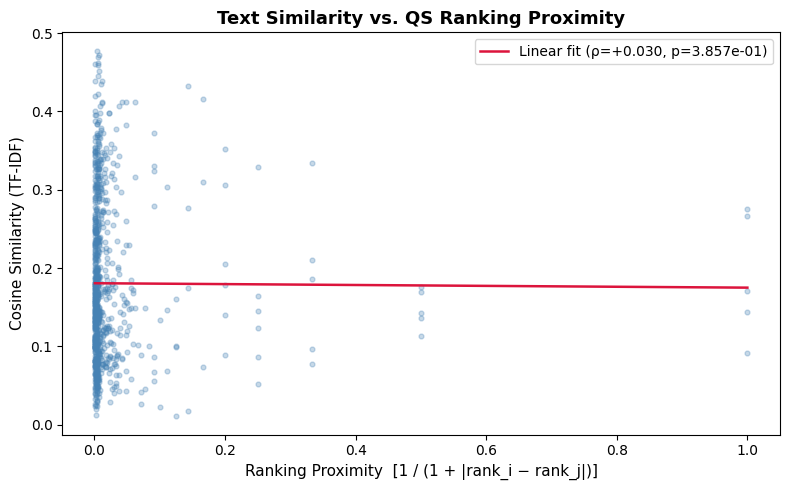

Saved → C:\Users\Shashwat\Documents\Text Analytics Project\outputs\figures\similarity_vs_rank_proximity.png


In [8]:
# ── Scatter plot: similarity vs. rank proximity ───────────────────────────────
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(prox_vec, sim_vec, alpha=0.3, s=12, color='steelblue')
# regression line
m, b = np.polyfit(prox_vec, sim_vec, 1)
x_line = np.linspace(prox_vec.min(), prox_vec.max(), 100)
ax.plot(x_line, m * x_line + b, color='crimson', linewidth=1.8,
        label=f'Linear fit (ρ={rho:+.3f}, p={pval:.3e})')
ax.set_xlabel('Ranking Proximity  [1 / (1 + |rank_i − rank_j|)]', fontsize=11)
ax.set_ylabel('Cosine Similarity (TF-IDF)', fontsize=11)
ax.set_title('Text Similarity vs. QS Ranking Proximity', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'similarity_vs_rank_proximity.png', dpi=150)
plt.show()
print(f'Saved → {FIGURES_DIR / "similarity_vs_rank_proximity.png"}')

---
## 6. Same-Tier vs. Cross-Tier Similarity (RQ2)

Do universities in the same ranking tier write more similarly to each other than to universities in different tiers?

In [9]:
tiers = df_available['tier'].values

same_tier_sims, cross_tier_sims = [], []
for i in range(N):
    for j in range(i + 1, N):
        if tiers[i] == tiers[j]:
            same_tier_sims.append(sim_matrix[i, j])
        else:
            cross_tier_sims.append(sim_matrix[i, j])

# Mann-Whitney U test
stat, p_mw = stats.mannwhitneyu(same_tier_sims, cross_tier_sims, alternative='greater')

print('=' * 55)
print('  Same-Tier vs. Cross-Tier Similarity')
print('=' * 55)
print(f'  Same-tier pairs  : n={len(same_tier_sims):,}  mean={np.mean(same_tier_sims):.4f}')
print(f'  Cross-tier pairs : n={len(cross_tier_sims):,}  mean={np.mean(cross_tier_sims):.4f}')
print(f'  Mann-Whitney U   : stat={stat:.1f}  p={p_mw:.4e}')
if p_mw < 0.05:
    print('  ✓ Same-tier universities are significantly MORE similar (α=0.05)')
else:
    print('  ✗ No significant difference between same-tier and cross-tier similarity')

  Same-Tier vs. Cross-Tier Similarity
  Same-tier pairs  : n=310  mean=0.1844
  Cross-tier pairs : n=551  mean=0.1782
  Mann-Whitney U   : stat=87173.0  p=3.0692e-01
  ✗ No significant difference between same-tier and cross-tier similarity


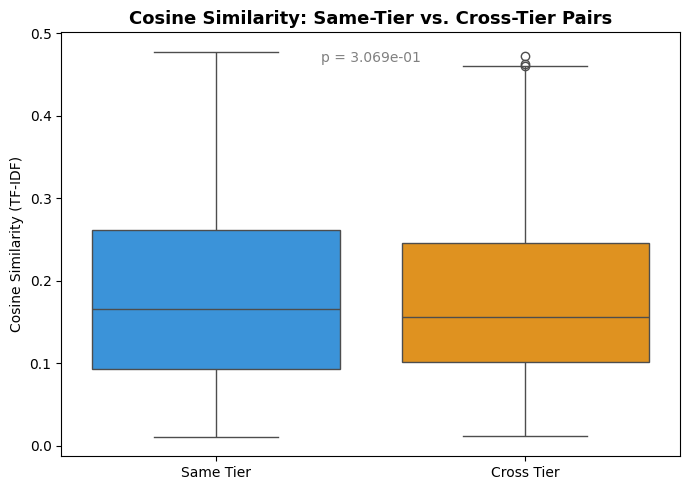

In [10]:
# ── Box plot: similarity distribution by tier pair ────────────────────────────
tier_pairs = []
for i in range(N):
    for j in range(i + 1, N):
        pair_label = 'Same Tier' if tiers[i] == tiers[j] else 'Cross Tier'
        tier_pairs.append({'pair_type': pair_label, 'similarity': sim_matrix[i, j]})

tp_df = pd.DataFrame(tier_pairs)

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=tp_df, x='pair_type', y='similarity',
            palette={'Same Tier': '#2196F3', 'Cross Tier': '#FF9800'}, ax=ax)
ax.set_title('Cosine Similarity: Same-Tier vs. Cross-Tier Pairs', fontsize=13, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Cosine Similarity (TF-IDF)')
ax.annotate(f'p = {p_mw:.3e}', xy=(0.5, 0.93), xycoords='axes fraction',
            ha='center', fontsize=10,
            color='green' if p_mw < 0.05 else 'grey')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'same_vs_cross_tier_similarity.png', dpi=150)
plt.show()

---
## 7. Similarity Heatmap

Visualise the full N × N similarity matrix, sorted by QS rank.

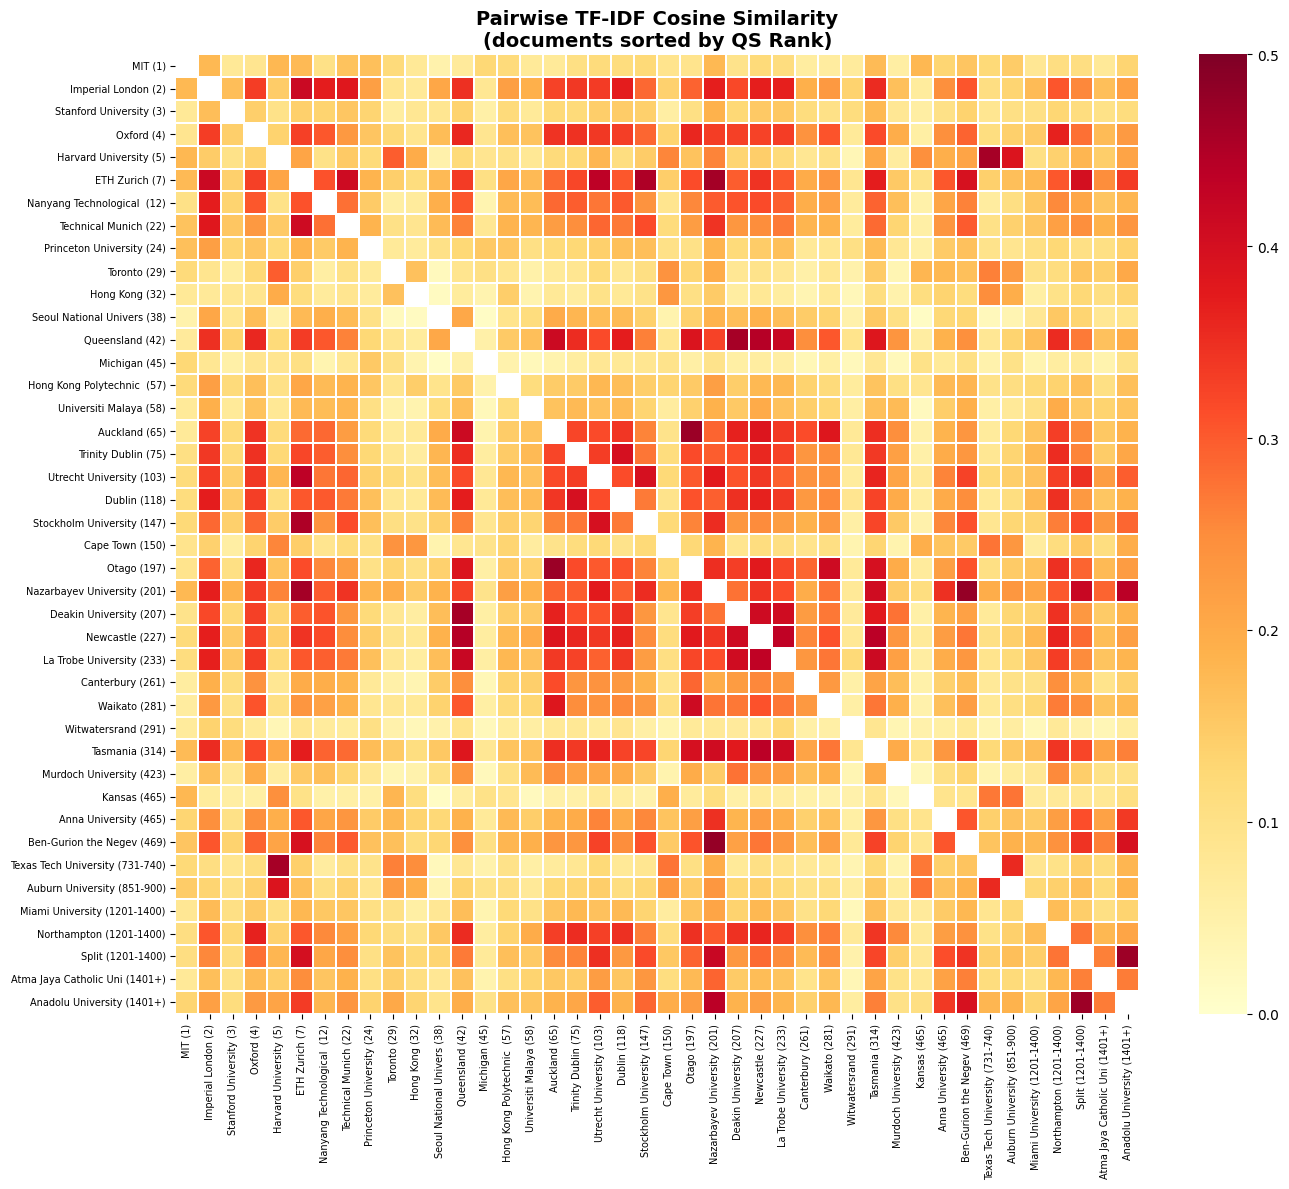

Saved → C:\Users\Shashwat\Documents\Text Analytics Project\outputs\figures\similarity_heatmap.png


In [11]:
# Sort by numeric rank
sort_order = df_available['qs_rank_numeric'].argsort().values
sorted_labels = df_available.iloc[sort_order]['label'].values
sorted_matrix = sim_matrix[np.ix_(sort_order, sort_order)]

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.eye(N, dtype=bool)   # mask diagonal (always 1)
sorted_mask = mask[np.ix_(sort_order, sort_order)]

sns.heatmap(
    sorted_matrix,
    xticklabels=sorted_labels,
    yticklabels=sorted_labels,
    mask=sorted_mask,
    cmap='YlOrRd',
    vmin=0, vmax=0.5,
    linewidths=0.3,
    ax=ax
)
ax.set_title(
    'Pairwise TF-IDF Cosine Similarity\n(documents sorted by QS Rank)',
    fontsize=14, fontweight='bold'
)
ax.tick_params(axis='x', rotation=90, labelsize=7)
ax.tick_params(axis='y', rotation=0, labelsize=7)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'similarity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved → {FIGURES_DIR / "similarity_heatmap.png"}')

---
## 8. Hierarchical Clustering

Using Ward linkage on the TF-IDF vectors.  
The dendrogram leaf labels are coloured by QS tier to visually assess cluster-tier alignment.

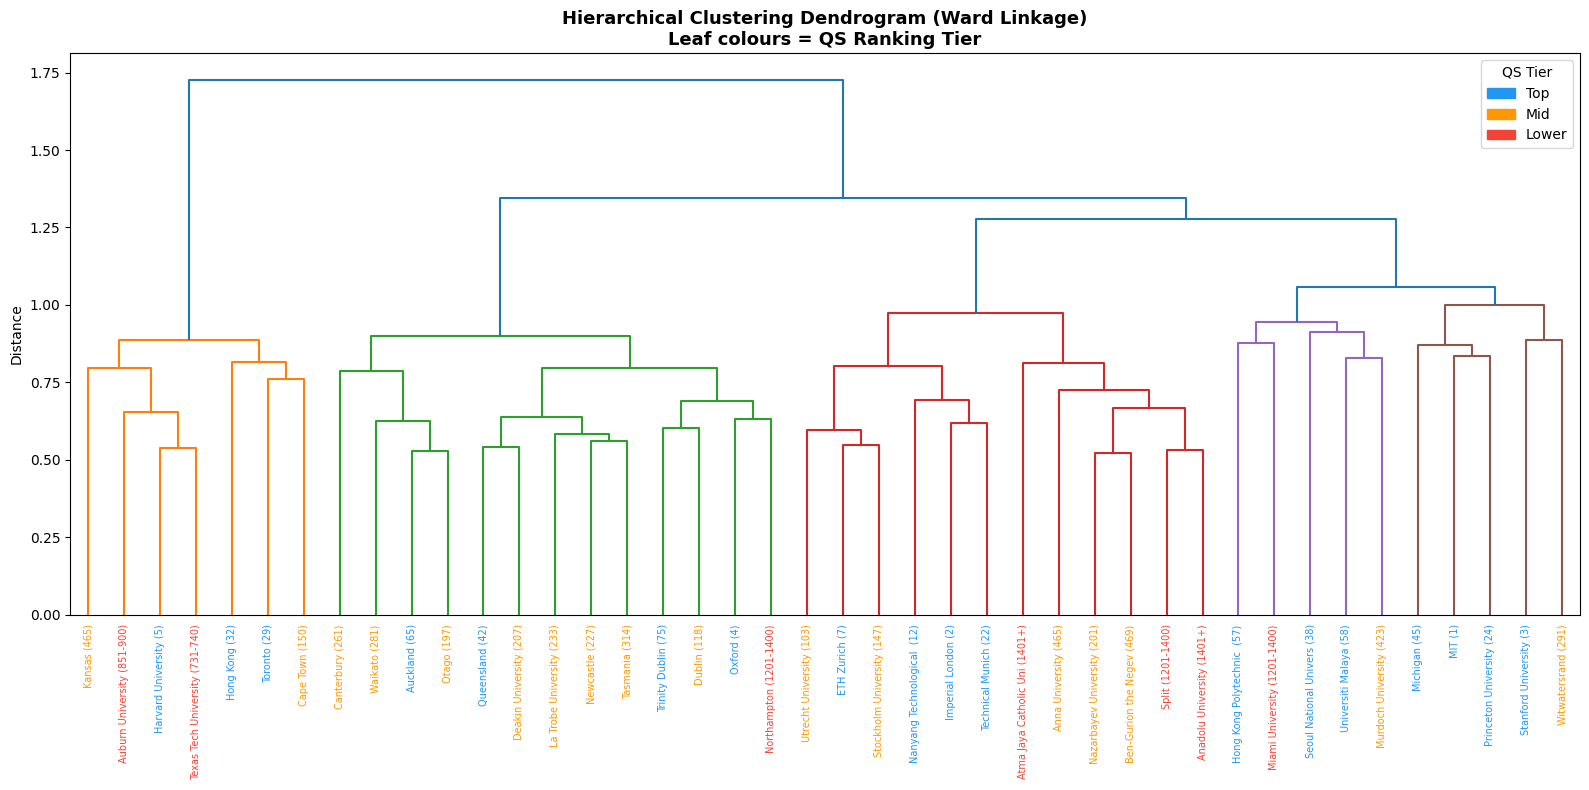

Saved → C:\Users\Shashwat\Documents\Text Analytics Project\outputs\figures\dendrogram.png


In [12]:
# Distance matrix from similarity matrix
dist_matrix = 1.0 - sim_matrix
np.fill_diagonal(dist_matrix, 0)
dist_condensed = squareform(dist_matrix)

Z = linkage(dist_condensed, method='ward')

# ── Tier colour map for leaf labels ──────────────────────────────────────────
tier_list = df_available['label'].map(
    dict(zip(df_available['label'], df_available['tier']))
).values

fig, ax = plt.subplots(figsize=(16, 8))
dend = dendrogram(
    Z,
    labels=df_available['label'].values,
    leaf_rotation=90,
    leaf_font_size=7,
    ax=ax,
    color_threshold=0.6 * max(Z[:, 2]),
)

# Colour x-tick labels by tier
xlabels = ax.get_xmajorticklabels()
label_to_tier = dict(zip(df_available['label'], df_available['tier']))
for lbl in xlabels:
    tier = label_to_tier.get(lbl.get_text(), 'Mid')
    lbl.set_color(TIER_COLORS.get(tier, 'black'))

# Legend
patches = [mpatches.Patch(color=c, label=t) for t, c in TIER_COLORS.items()]
ax.legend(handles=patches, title='QS Tier', loc='upper right')
ax.set_title('Hierarchical Clustering Dendrogram (Ward Linkage)\nLeaf colours = QS Ranking Tier',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Distance')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved → {FIGURES_DIR / "dendrogram.png"}')

---
## 9. K-Means Clustering

We try k = 2, 3, 4, 5 and select the best k using the **Silhouette Score** (higher = better-separated clusters).  
k = 3 corresponds to our three ranking tiers (Top / Mid / Lower).

In [13]:
# ── Silhouette analysis ───────────────────────────────────────────────────────
dense_matrix = tfidf_matrix.toarray()
k_range = range(2, min(7, N - 1))
sil_scores = {}

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_km = km.fit_predict(dense_matrix)
    score = silhouette_score(dense_matrix, labels_km)
    sil_scores[k] = score
    print(f'  k={k}  silhouette={score:.4f}')

best_k = max(sil_scores, key=sil_scores.get)
print(f'\nBest k = {best_k}  (silhouette = {sil_scores[best_k]:.4f})')

  k=2  silhouette=0.0691
  k=3  silhouette=0.0251
  k=4  silhouette=0.0271
  k=5  silhouette=0.0283
  k=6  silhouette=0.0205

Best k = 2  (silhouette = 0.0691)


In [14]:
# ── Fit K-Means with k=3 (tier-aligned) AND best_k ───────────────────────────
km3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_available['kmeans_cluster_k3'] = km3.fit_predict(dense_matrix)

if best_k != 3:
    km_best = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
    df_available['kmeans_cluster_best'] = km_best.fit_predict(dense_matrix)

# How well do k=3 clusters align with tier labels?
from sklearn.metrics import adjusted_rand_score
le = LabelEncoder()
tier_encoded = le.fit_transform(df_available['tier'])
ari = adjusted_rand_score(tier_encoded, df_available['kmeans_cluster_k3'])
print(f'Adjusted Rand Index (k=3 clusters vs. tier labels): {ari:.4f}')
print('  (1.0 = perfect alignment, 0.0 = random, −1.0 = worse than random)\n')

# Cross-tabulation
print(pd.crosstab(df_available['tier'], df_available['kmeans_cluster_k3'],
                  rownames=['Tier'], colnames=['K-Means cluster (k=3)']))

Adjusted Rand Index (k=3 clusters vs. tier labels): -0.0240
  (1.0 = perfect alignment, 0.0 = random, −1.0 = worse than random)

K-Means cluster (k=3)  0  1  2
Tier                          
Lower                  4  2  1
Mid                    8  2  7
Top                    9  4  5


---
## 10. PCA Scatter Plot

Reduce the TF-IDF vectors to 2D using PCA to visualise how universities cluster in the text space.  
Points are coloured by **QS tier** and shaped by **region**.

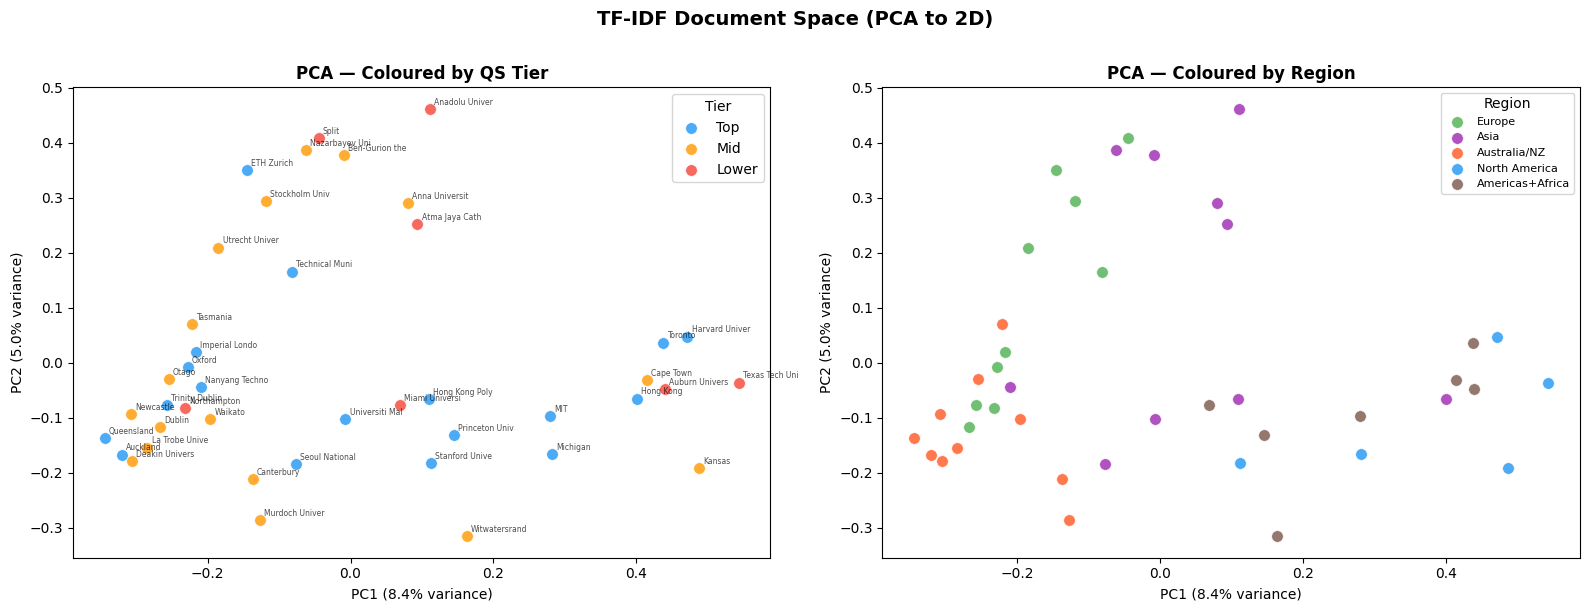

Saved → C:\Users\Shashwat\Documents\Text Analytics Project\outputs\figures\pca_scatter.png


In [15]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(dense_matrix)
explained = pca.explained_variance_ratio_

df_available['pca_x'] = coords[:, 0]
df_available['pca_y'] = coords[:, 1]

# ── Plot coloured by tier ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for tier, color in TIER_COLORS.items():
    mask = df_available['tier'] == tier
    axes[0].scatter(
        df_available.loc[mask, 'pca_x'],
        df_available.loc[mask, 'pca_y'],
        c=color, label=tier, s=70, alpha=0.8, edgecolors='white', linewidths=0.5
    )
for _, row in df_available.iterrows():
    axes[0].annotate(row['label'].split('(')[0].strip()[:14],
                     (row['pca_x'], row['pca_y']),
                     fontsize=5.5, alpha=0.7,
                     xytext=(3, 3), textcoords='offset points')
axes[0].set_xlabel(f'PC1 ({explained[0]*100:.1f}% variance)', fontsize=10)
axes[0].set_ylabel(f'PC2 ({explained[1]*100:.1f}% variance)', fontsize=10)
axes[0].set_title('PCA — Coloured by QS Tier', fontsize=12, fontweight='bold')
axes[0].legend(title='Tier')

# ── Plot coloured by region ───────────────────────────────────────────────────
for region, color in REGION_COLORS.items():
    mask = df_available['region'] == region
    axes[1].scatter(
        df_available.loc[mask, 'pca_x'],
        df_available.loc[mask, 'pca_y'],
        c=color, label=region, s=70, alpha=0.8, edgecolors='white', linewidths=0.5
    )
axes[1].set_xlabel(f'PC1 ({explained[0]*100:.1f}% variance)', fontsize=10)
axes[1].set_ylabel(f'PC2 ({explained[1]*100:.1f}% variance)', fontsize=10)
axes[1].set_title('PCA — Coloured by Region', fontsize=12, fontweight='bold')
axes[1].legend(title='Region', fontsize=8)

plt.suptitle('TF-IDF Document Space (PCA to 2D)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved → {FIGURES_DIR / "pca_scatter.png"}')

---
## 11. Top Keywords per Ranking Tier (RQ3)

For each tier (Top / Mid / Lower), identify the vocabulary that is most characteristic —
i.e., highest average TF-IDF weight — to answer *which linguistic features best predict ranking tier?*

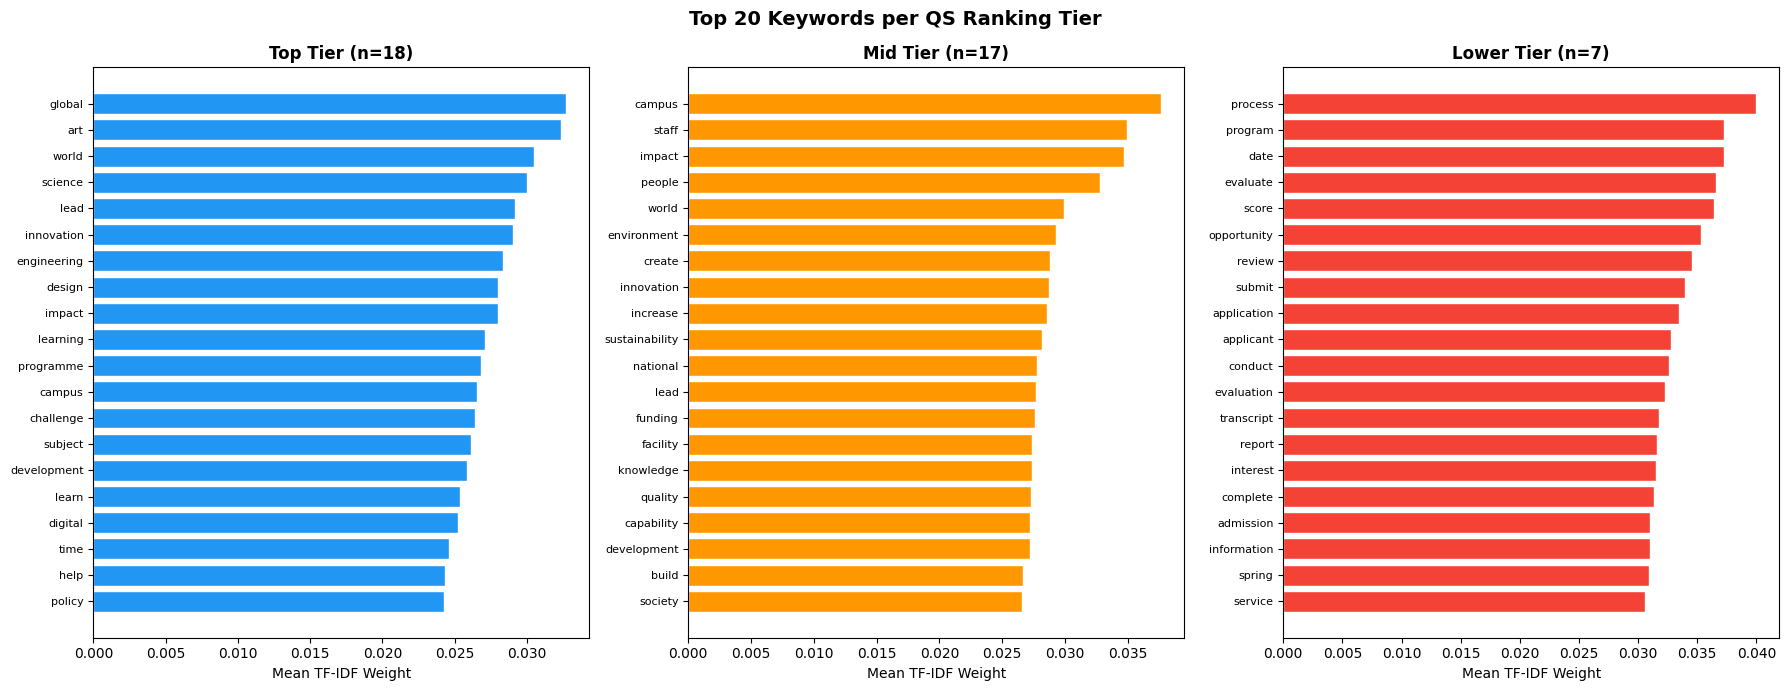

Saved → C:\Users\Shashwat\Documents\Text Analytics Project\outputs\figures\top_keywords_per_tier.png


In [16]:
tfidf_dense = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vocab,
    index=df_available.index
)
tfidf_dense['tier'] = df_available['tier'].values

N_TOP = 20  # how many top keywords to show per tier
tier_keywords = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 7))
for ax, tier in zip(axes, ['Top', 'Mid', 'Lower']):
    group = tfidf_dense[tfidf_dense['tier'] == tier].drop(columns='tier')
    mean_weights = group.mean().sort_values(ascending=False).head(N_TOP)
    tier_keywords[tier] = mean_weights

    ax.barh(mean_weights.index[::-1], mean_weights.values[::-1],
            color=TIER_COLORS[tier], edgecolor='white')
    ax.set_title(f'{tier} Tier (n={len(group)})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Mean TF-IDF Weight')
    ax.tick_params(axis='y', labelsize=8)

plt.suptitle('Top 20 Keywords per QS Ranking Tier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'top_keywords_per_tier.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved → {FIGURES_DIR / "top_keywords_per_tier.png"}')

In [17]:
# ── Tier-exclusive keywords — appear in Top but NOT in Lower ─────────────────
top_kws   = set(tier_keywords.get('Top',   pd.Series()).head(50).index)
mid_kws   = set(tier_keywords.get('Mid',   pd.Series()).head(50).index)
lower_kws = set(tier_keywords.get('Lower', pd.Series()).head(50).index)

print('Keywords exclusive to Top-tier (not in Lower-tier top-50):')
print(sorted(top_kws - lower_kws))

print('\nKeywords exclusive to Lower-tier (not in Top-tier top-50):')
print(sorted(lower_kws - top_kws))

Keywords exclusive to Top-tier (not in Lower-tier top-50):
['art', 'campus', 'challenge', 'design', 'development', 'digital', 'engineering', 'global', 'help', 'impact', 'innovation', 'lead', 'learn', 'learning', 'policy', 'programme', 'science', 'subject', 'time', 'world']

Keywords exclusive to Lower-tier (not in Top-tier top-50):
['admission', 'applicant', 'application', 'complete', 'conduct', 'date', 'evaluate', 'evaluation', 'information', 'interest', 'opportunity', 'process', 'program', 'report', 'review', 'score', 'service', 'spring', 'submit', 'transcript']


---
## 12. Does Lower-Ranked Language Mimic Top-Ranked? (RQ5)

Compute the average similarity between each Lower-tier university and:  
a) all Top-tier universities  
b) all other Lower-tier universities  

If lower-ranked universities mimic top-ranked language, (a) should be >= (b).

In [18]:
top_idx   = df_available[df_available['tier'] == 'Top'].index.tolist()
mid_idx   = df_available[df_available['tier'] == 'Mid'].index.tolist()
lower_idx = df_available[df_available['tier'] == 'Lower'].index.tolist()

print('Average similarity of Lower-tier universities to each group:')
results_rq5 = []
for i in lower_idx:
    name = df_available.loc[i, 'university']
    sim_to_top   = np.mean([sim_matrix[i, j] for j in top_idx   if j != i]) if top_idx   else 0
    sim_to_mid   = np.mean([sim_matrix[i, j] for j in mid_idx   if j != i]) if mid_idx   else 0
    sim_to_lower = np.mean([sim_matrix[i, j] for j in lower_idx if j != i]) if len(lower_idx) > 1 else 0
    results_rq5.append({'university': name,
                         'sim_to_top': sim_to_top,
                         'sim_to_mid': sim_to_mid,
                         'sim_to_lower': sim_to_lower})

rq5_df = pd.DataFrame(results_rq5)
if not rq5_df.empty:
    print(rq5_df.to_string(index=False, float_format='{:.4f}'.format))
    print(f'\nMean sim to Top   : {rq5_df["sim_to_top"].mean():.4f}')
    print(f'Mean sim to Mid   : {rq5_df["sim_to_mid"].mean():.4f}')
    print(f'Mean sim to Lower : {rq5_df["sim_to_lower"].mean():.4f}')
else:
    print('No Lower-tier documents available yet.')

Average similarity of Lower-tier universities to each group:
                   university  sim_to_top  sim_to_mid  sim_to_lower
    University of Northampton      0.2083      0.2629        0.1786
          University of Split      0.1933      0.2469        0.2432
           Anadolu University      0.1791      0.2239        0.2409
Atma Jaya Catholic University      0.1348      0.1656        0.1739
        Texas Tech University      0.1252      0.1207        0.1628
            Auburn University      0.1411      0.1467        0.1820
             Miami University      0.1228      0.1337        0.1273

Mean sim to Top   : 0.1578
Mean sim to Mid   : 0.1858
Mean sim to Lower : 0.1870


---
## 13. Export Results

In [19]:
# ── Similarity matrix CSV ─────────────────────────────────────────────────────
sim_df.to_csv(OUTPUT_DIR / 'similarity_matrix.csv')
print(f'Saved: {OUTPUT_DIR / "similarity_matrix.csv"}')

# ── Cluster assignments CSV ───────────────────────────────────────────────────
cluster_cols = ['university', 'country', 'region', 'qs_rank', 'qs_rank_numeric',
                'tier', 'kmeans_cluster_k3', 'pca_x', 'pca_y', 'word_count']
df_available[cluster_cols].to_csv(OUTPUT_DIR / 'cluster_assignments.csv', index=False)
print(f'Saved: {OUTPUT_DIR / "cluster_assignments.csv"}')

# ── Top keywords per tier CSV ─────────────────────────────────────────────────
kw_rows = []
for tier, series in tier_keywords.items():
    for rank, (term, weight) in enumerate(series.items(), 1):
        kw_rows.append({'tier': tier, 'rank': rank, 'term': term, 'mean_tfidf': weight})
pd.DataFrame(kw_rows).to_csv(OUTPUT_DIR / 'top_keywords_per_tier.csv', index=False)
print(f'Saved: {OUTPUT_DIR / "top_keywords_per_tier.csv"}')

# ── Summary statistics ────────────────────────────────────────────────────────
summary = {
    'n_documents': N,
    'spearman_rho': round(rho, 4),
    'spearman_pvalue': round(pval, 6),
    'mean_same_tier_sim': round(np.mean(same_tier_sims), 4),
    'mean_cross_tier_sim': round(np.mean(cross_tier_sims), 4),
    'kmeans_k3_ari': round(ari, 4),
    'best_k_silhouette': best_k,
}
pd.DataFrame([summary]).to_csv(OUTPUT_DIR / 'summary_statistics.csv', index=False)
print(f'Saved: {OUTPUT_DIR / "summary_statistics.csv"}')

print('\n=== All outputs saved ===')
for f in sorted(OUTPUT_DIR.rglob('*')):
    if f.is_file():
        print(f'  {f.relative_to(BASE_DIR)}')

Saved: C:\Users\Shashwat\Documents\Text Analytics Project\outputs\similarity_matrix.csv
Saved: C:\Users\Shashwat\Documents\Text Analytics Project\outputs\cluster_assignments.csv
Saved: C:\Users\Shashwat\Documents\Text Analytics Project\outputs\top_keywords_per_tier.csv
Saved: C:\Users\Shashwat\Documents\Text Analytics Project\outputs\summary_statistics.csv

=== All outputs saved ===
  outputs\cluster_assignments.csv
  outputs\figures\dendrogram.png
  outputs\figures\pca_scatter.png
  outputs\figures\same_vs_cross_tier_similarity.png
  outputs\figures\similarity_heatmap.png
  outputs\figures\similarity_vs_rank_proximity.png
  outputs\figures\top_keywords_per_tier.png
  outputs\similarity_matrix.csv
  outputs\summary_statistics.csv
  outputs\top_keywords_per_tier.csv


---
## 14. Results Summary

Run the cell below after completing the full pipeline to print a clean summary of all findings.

In [20]:
print('=' * 65)
print('  APPROACH A — RESULTS SUMMARY')
print('=' * 65)
print(f'  Documents analysed       : {N}')
print(f'  TF-IDF vocabulary size   : {len(vocab):,} features')
print()
print('  RQ1 — Does text similarity correlate with ranking proximity?')
print(f'    Spearman ρ = {rho:+.4f}   p = {pval:.4e}')
print(f'    Significant? {"YES" if pval < 0.05 else "NO"}')
print()
print('  RQ2 — Do same-tier universities write more similarly?')
print(f'    Mean same-tier sim  = {np.mean(same_tier_sims):.4f}')
print(f'    Mean cross-tier sim = {np.mean(cross_tier_sims):.4f}')
print(f'    Mann-Whitney p      = {p_mw:.4e}')
print(f'    Significant? {"YES" if p_mw < 0.05 else "NO"}')
print()
print('  RQ3 — Top keywords per tier:')
for tier in ['Top', 'Mid', 'Lower']:
    kws = ', '.join(tier_keywords.get(tier, pd.Series()).head(8).index.tolist())
    print(f'    {tier:6s}: {kws}')
print()
print('  Clustering:')
print(f'    K-Means (k=3) Adjusted Rand Index vs. tiers = {ari:.4f}')
print(f'    Best k by silhouette = {best_k}  (score={sil_scores[best_k]:.4f})')
print('=' * 65)

  APPROACH A — RESULTS SUMMARY
  Documents analysed       : 42
  TF-IDF vocabulary size   : 5,000 features

  RQ1 — Does text similarity correlate with ranking proximity?
    Spearman ρ = +0.0296   p = 3.8574e-01
    Significant? NO

  RQ2 — Do same-tier universities write more similarly?
    Mean same-tier sim  = 0.1844
    Mean cross-tier sim = 0.1782
    Mann-Whitney p      = 3.0692e-01
    Significant? NO

  RQ3 — Top keywords per tier:
    Top   : global, art, world, science, lead, innovation, engineering, design
    Mid   : campus, staff, impact, people, world, environment, create, innovation
    Lower : process, program, date, evaluate, score, opportunity, review, submit

  Clustering:
    K-Means (k=3) Adjusted Rand Index vs. tiers = -0.0240
    Best k by silhouette = 2  (score=0.0691)
